In [47]:
import numpy as np
import pandas as pd
from random import randint
import math
from PIL import Image, ImageDraw
from PIL import ImagePath 
from imutils import rotate
import matplotlib.pyplot as plt
from skimage.transform import radon



# from dataset_generator import generate_polygon, calculate_angles
from dataset_generator import create_dataset, get_non_binary_angles #, generate_polygon, generate_polygon_subroutine
from utils import mse_error, reconstruct

average mse error for 50 polygon-shaped pics: 0.0


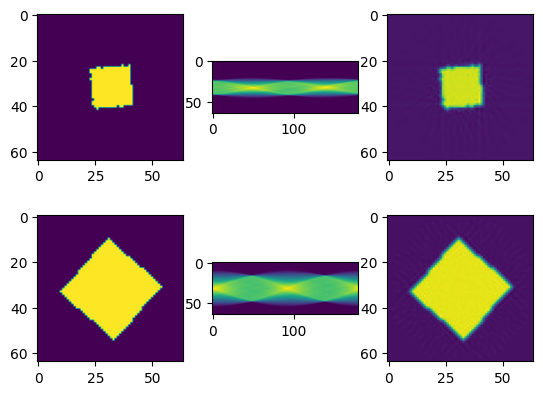

In [48]:
# images_list, sinograms_list, angles_list = create_dataset(30000, single_side_size = 4, img_size = 91)
images_list, sinograms_list, angles_list = create_dataset(12000, single_side_size = 4, img_size = 64)
reconstruct_list = reconstruct(sinograms_list)
print("average mse error for 50 polygon-shaped pics:", mse_error(images_list, reconstruct_list))
f, axarr = plt.subplots(2,3)
axarr[0,0].imshow(images_list[0]) 
axarr[0,1].imshow(sinograms_list[0])
axarr[0,2].imshow(reconstruct_list[0])
axarr[1,0].imshow(images_list[1])
axarr[1,1].imshow(sinograms_list[1])
axarr[1,2].imshow(reconstruct_list[1])

# Sandbox area:

In [49]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt


def create_model(img_size = 64):
    model = tf.keras.Sequential([
        layers.Conv2D(32, (5, 5), activation='relu', kernel_initializer='random_normal',),
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='random_normal',),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='random_normal',),
        layers.MaxPooling2D((2, 2)),

        # layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='random_normal',),
        # layers.MaxPooling2D((2, 2)), # Might increase performance because it decreases parameters (which is why CNN was created for in the first place)
        # Sams model has 85% of params in dense layer
        tf.keras.layers.Flatten(),
        
        tf.keras.layers.Dense(500, activation="relu", kernel_initializer='random_normal',),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(180, activation="sigmoid", kernel_initializer='random_normal',),
    ])

    return model

In [50]:
model = create_model(64)
model.build((None, 64, 180, 1))

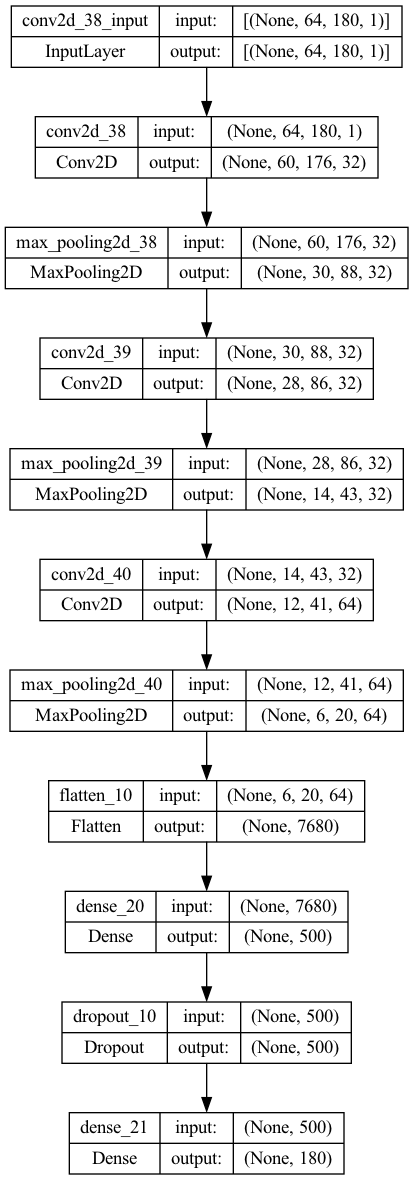

In [51]:
# model = create_model(64)
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=96,
)

In [52]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.MeanAbsoluteError(),
              metrics=['accuracy'])

checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='loss',
    mode='min',
    save_best_only=True)

# callbacks = [
#              EarlyStopping(patience=2),
#              model_checkpoint_callback,
# ]

In [53]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_38 (Conv2D)          (None, 60, 176, 32)       832       
                                                                 
 max_pooling2d_38 (MaxPoolin  (None, 30, 88, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_39 (Conv2D)          (None, 28, 86, 32)        9248      
                                                                 
 max_pooling2d_39 (MaxPoolin  (None, 14, 43, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_40 (Conv2D)          (None, 12, 41, 64)        18496     
                                                                 
 max_pooling2d_40 (MaxPoolin  (None, 6, 20, 64)      

In [54]:
# def transform_angles_data(angles_list, high_nr = 100, neighbouring_angles = 10, drop = 10):
#     assert np.array(angles_list).ndim == 2
#     angles_list_copy = np.array(angles_list).copy()
#     # print("neighbouring_angles:", neighbouring_angles)
#     output_angles_list = []
#     for angles in angles_list_copy:
#         # print("angles:", angles)
#         angles_indices = get_non_binary_angles(angles)
#         # print("angles_indices:", angles_indices)
#         for indice in angles_indices:
#             # print("1st iterated")
#             angles[indice] = high_nr
#             for i in range(neighbouring_angles):
#                 # print("iterated")
#                 angles[indice-i] = high_nr - i * drop
#                 angles[(indice+i)%180] = high_nr - i * drop
#         output_angles_list.append(angles)
#     return np.array(output_angles_list)
# 

def transform_angles_data(angles_list, high_nr = 100, neighbouring_angles = 10, drop = 10):
    def sigmoid(x):
        return 2 / (1 + math.exp(-x)) - 1
    assert np.array(angles_list).ndim == 2
    angles_list_copy = np.array(angles_list).copy()
    output_angles = []
    
    for angles in angles_list_copy:
        angles_indices = get_non_binary_angles(angles)
        nr_angles = len(angles_indices)
        # Change from -10 to 10  (therefore value 20)
        CONST = int(180/2/nr_angles)
        for angle in angles_indices:
            for i in range(0,CONST + 1):
                if i == 0 : iter = 10
                else : iter = round(10 - (20 * i / CONST),2)
                angles[(angle + i)%180] = iter
                angles[angle - i] = iter
        # Transform values from -10 to 10 into more smooth line using sigmoid function
        angles_ = []
        for iter, angle in enumerate(angles):
            angles_.append(round(sigmoid(angle),3))
        output_angles.append(angles_)

    return output_angles

transformed = transform_angles_data(angles_list)

In [55]:
def get_split(X, y, split_pct = 70):
    assert type(X) in [np.ndarray, list] and type(y) in [np.ndarray, list]
    assert len(X) == len(y)
    assert split_pct > 50 and split_pct < 90

    if type(X) != np.array:
        X = np.array(X)
    if type(y) != np.array:
        y = np.array(y)

    index = int(split_pct/100 * len(X))
    X_train = X[:index]
    X_test = X[index:]

    y_train = y[:index]
    y_test = y[index:]

    return X_train, X_test, y_train, y_test


X_train, X_test, y_train, y_test = get_split(sinograms_list, transformed)


In [64]:
history = model.fit(X_train,y_train, batch_size=300, epochs=200,validation_data=(X_test,y_test))
# history = model.fit(X_train,y_train, batch_size=2000, epochs=600,validation_data=(X_test,y_test))

Epoch 1/200
28/28 [==============================] - 52s 2s/step - loss: 0.4190 - accuracy: 0.0485 - val_loss: 0.4173 - val_accuracy: 0.0608
Epoch 2/200
28/28 [==============================] - 49s 2s/step - loss: 0.4186 - accuracy: 0.0526 - val_loss: 0.4171 - val_accuracy: 0.0572
Epoch 3/200
28/28 [==============================] - 50s 2s/step - loss: 0.4183 - accuracy: 0.0486 - val_loss: 0.4170 - val_accuracy: 0.0569
Epoch 4/200
28/28 [==============================] - 50s 2s/step - loss: 0.4182 - accuracy: 0.0477 - val_loss: 0.4167 - val_accuracy: 0.0522
Epoch 5/200
28/28 [==============================] - 50s 2s/step - loss: 0.4180 - accuracy: 0.0524 - val_loss: 0.4168 - val_accuracy: 0.0464
Epoch 6/200
28/28 [==============================] - 51s 2s/step - loss: 0.4179 - accuracy: 0.0508 - val_loss: 0.4164 - val_accuracy: 0.0625
Epoch 7/200
28/28 [==============================] - 51s 2s/step - loss: 0.4177 - accuracy: 0.0533 - val_loss: 0.4161 - val_accuracy: 0.0550
Epoch 8/200
2

KeyboardInterrupt: 

In [67]:
test = np.expand_dims(np.array(sinograms_list[0]), axis = 0)
prediction = model.predict(test)

1/1 [==============================] - 0s 37ms/step


In [70]:
for a,b in  zip(transformed[0], prediction[0]):
    print(round(a,1),round(b,1))

1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
0.9 0.9
0.9 0.9
0.8 0.8
0.8 0.8
0.8 0.8
0.5 0.5
0.5 0.5
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
-0.5 0.0
-0.5 0.0
-0.8 0.0
-0.8 0.0
-0.8 0.0
-0.9 0.0
-0.9 0.0
-1.0 0.0
-1.0 0.0
-1.0 0.0
-1.0 0.0
-1.0 0.0
-1.0 0.0
-1.0 0.0
-1.0 0.0
-1.0 0.0
-1.0 0.0
-1.0 0.0
-1.0 0.0
-1.0 0.0
-1.0 0.0
-1.0 0.0
-1.0 0.0
-1.0 0.0
-1.0 0.0
-1.0 0.0
-1.0 0.0
-1.0 0.0
-1.0 0.0
-1.0 0.0
-1.0 0.0
-1.0 0.0
-1.0 0.0
-1.0 0.0
-0.9 0.0
-0.9 0.0
-0.8 0.0
-0.8 0.0
-0.8 0.0
-0.5 0.0
-0.5 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.5 0.4
0.5 0.5
0.8 0.7
0.8 0.8
0.8 0.8
0.9 0.9
0.9 0.9
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
1.0 1.0
0.9 0.9
0.9 0.9
0.8 0.8
0.8 0.8
0.8 0.8
0.5 0.5
0.5 0.5
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0